### Chains using LangGraph

In [1]:
from dotenv import load_dotenv
load_dotenv()

import os

groq_api_key = os.getenv("GROQ_API_KEY")

In [5]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages= [AIMessage(content="how can I help you", name="Model")]
messages.append(HumanMessage(content="Hi, I am Mounica", name="User"))
messages.append(AIMessage(content="Hi Mounica, how may I help", name="Model"))
messages.append(HumanMessage(content="Im planning to learn langgraph", name="User"))

for message in messages:
    message.pretty_print()


================================== Ai Message ==================================
Name: Model

how can I help you
================================ Human Message =================================
Name: User

Hi, I am Mounica
================================== Ai Message ==================================
Name: Model

Hi Mounica, how may I help
================================ Human Message =================================
Name: User

Im planning to learn langgraph


#### Chat Model

In [7]:
from langchain_groq import ChatGroq
model = ChatGroq(model="llama-3.1-8b-instant")
response=model.invoke(messages)
response.pretty_print()

================================== Ai Message ==================================

You're interested in learning Langgraph. Can you please provide more context or information about Langgraph? I'd be happy to help if you're looking for resources, tutorials, or general information about it.


In [8]:
response.response_metadata

{'token_usage': {'completion_tokens': 42,
  'prompt_tokens': 77,
  'total_tokens': 119,
  'completion_time': 0.081637631,
  'completion_tokens_details': None,
  'prompt_time': 0.00557929,
  'prompt_tokens_details': None,
  'queue_time': 0.05009183,
  'total_time': 0.087216921},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_4387d3edbb',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

#### Tools

* Tools can be integrated with LLM Models to interact with external systems. External systems can be API's, third party tools.

In [14]:
# tool function

def add(num1, num2):
    '''Add or Sum num1 and num2 and return value

    Arg:
    num1: int
    num2: int

    Result:
    result: int

    '''
    result = num1 + num2
    return result

    

In [15]:
tool_model = model.bind_tools([add])
tool_model

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000269E5B07990>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000269E5EB1690>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add or Sum num1 and num2 and return value Arg:\nnum1: int\nnum2: int Result:\nresult: int', 'parameters': {'properties': {'num1': {}, 'num2': {}}, 'required': ['num1', 'num2'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [21]:
res=tool_model.invoke('what is sum of 2 + 2')
res.tool_calls

[{'name': 'add',
  'args': {'num1': 2, 'num2': 2},
  'id': 'kdzj2kzjq',
  'type': 'tool_call'}]

#### Using messages as state

In [ ]:
from typing_extensions import TypedDict
from typing import Annotated, List
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    


In [28]:
#nodel definition

def llm_tool(state:State):
    return {"messages": tool_model.invoke(state['messages'])}


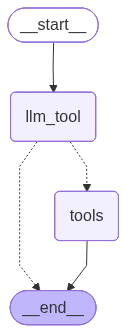

In [29]:
#graph workflow

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tools = ToolNode([add])

graph = StateGraph(State)

graph.add_node("llm_tool", llm_tool)
graph.add_node("tools", tools)


graph.add_edge(START, "llm_tool")
graph.add_conditional_edges("llm_tool", tools_condition)

#if latest message from model is tool call, then it routes to tools node
#if latest message from model is not a tool call, then it routes to END

graph_builder = graph.compile()
graph_builder

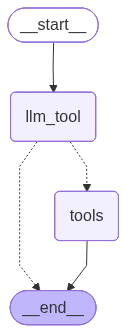

In [ ]:
# from IPython.display import Image, display
# display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [ ]:
#graph invocation to call tool

response = graph_builder.invoke({"messages": " what is sum of 3 and 3"})
response

{'messages': [HumanMessage(content=' what is sum of 3 and 3', additional_kwargs={}, response_metadata={}, id='79f8ad11-d38c-43be-85e8-1465c8d19709'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'pgyz3wnn6', 'function': {'arguments': '{"num1":3,"num2":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 271, 'total_tokens': 291, 'completion_time': 0.036076301, 'completion_tokens_details': None, 'prompt_time': 0.015045709, 'prompt_tokens_details': None, 'queue_time': 0.088722951, 'total_time': 0.05112201}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b3747-ef2e-7da0-8fbf-53d653d63325-0', tool_calls=[{'name': 'add', 'args': {'num1': 3, 'num2': 3}, 'id': 'pgyz3wnn6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 271, 'output_tokens': 20, 'total

In [33]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

 what is sum of 3 and 3
================================== Ai Message ==================================
Tool Calls:
  add (pgyz3wnn6)
 Call ID: pgyz3wnn6
  Args:
    num1: 3
    num2: 3
================================= Tool Message =================================
Name: add

6


In [35]:
#without tool call
response = graph_builder.invoke({"messages": " say two lines about gen ai"})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

 say two lines about gen ai
================================== Ai Message ==================================

Gen AI refers to the use of artificial intelligence to generate human-like content, such as text, images, and music. This technology is rapidly evolving and has many potential applications, including in areas like language translation, content creation, and customer service.
